## Gradient Boost Classifier:

Using a combination of governance characteristics and organizational characteristics (revenue, assets, ect.) I will predict salary using a Gradient Boost Classifier model.

In [34]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from scipy import stats
from scipy.special import boxcox, inv_boxcox
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from numpy import interp
import joblib

from sklearn.metrics import mean_squared_error


## IMPORT DATA

In [3]:
# import modeling dataset
features = pd.get_dummies(pd.read_csv('02.data/model_dataset_features_eng.csv'))
X = features.drop(['reportable_comp'], axis=1)

y = pd.read_csv('02.data/target_categories_box_cox.csv', header=None, squeeze=True)

In [4]:
# verify the size of target and
# feature datasets are the same
X.shape[0] == y.shape[0]

True

## Gradient Boost Classifier
<a id='gbc'></a>

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [10]:
# randomly choose 10K rows
# to parameter tune on
feature_sample = pd.concat([
    X_train,
    y_train
], axis=1).sample(n=10000)

X_train_sample = feature_sample.drop(0, axis=1)
y_train_sample = feature_sample.loc[:, 0]

In [11]:
gbc = ensemble.GradientBoostingClassifier()

param_grid = { 
    'learning_rate': [0.5, 0.25, 0.1, 0.05, 0.01],
    'n_estimators': [10, 20, 50, 100, 200],
    'max_depth' : [3, 10, 20]
}

cv_gbc = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=3)
cv_gbc.fit(X_train_sample, y_train_sample)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [13]:
cv_gbc.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [7]:
# save best parameters
joblib.dump({'learning_rate': 0.1, 
 'max_depth': 3, 
 'n_estimators': 100}, '08.models/gbc_params.pkl')

['08.models/gbc_params.pkl']

In [13]:
gbc = ensemble.GradientBoostingClassifier(**joblib.load('08.models/gbc_params.pkl'))

In [14]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [16]:
# save model
joblib.dump(gbc, '08.models/gbc_model.pkl')

['08.models/gbc_model.pkl']

In [8]:
# load model from pickel
gbc = joblib.load('08.models/gbc_model.pkl')

In [18]:
# train model
cross_val_score(gbc, X_train, y_train, cv=5)

array([0.24541118, 0.24874255, 0.25501789, 0.25022045, 0.24893661])

In [19]:
gbc.score(X_train, y_train)

0.282774429773154

In [17]:
# test model on unseen data
gbc.score(X_test, y_test)

0.2550304941293615

In [21]:
# predict categores
pred = gbc.predict(X_test)

In [22]:
# create confusion matrix and
# normalize the matrix to more accurately 
# compare which predictions the model is getting wrong
norm_conf_matrix = confusion_matrix(y_test, pred) / \
confusion_matrix(y_test, pred).sum(axis=1, keepdims=True)

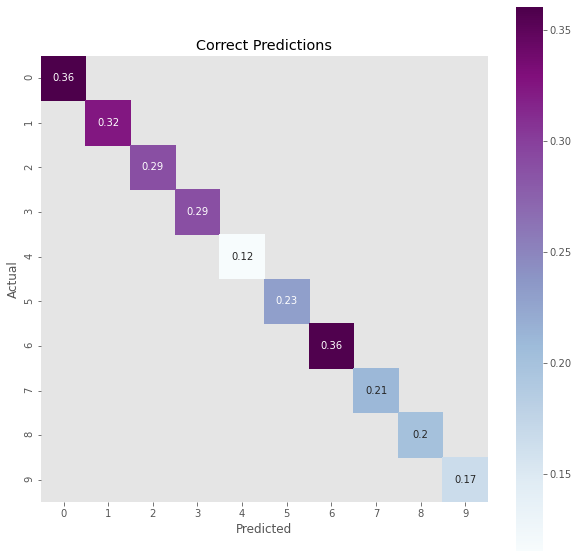

In [33]:
# display only the diagonal values
# representing values the model correctly predicted
plt.figure(figsize=(10, 10))

sns.heatmap(np.where(np.diagflat(np.diagonal(norm_conf_matrix))
            ==0, np.nan, np.diagflat(np.diagonal(norm_conf_matrix))),
            cmap='BuPu',
            annot=True,
            square=True,
            );
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Correct Predictions');

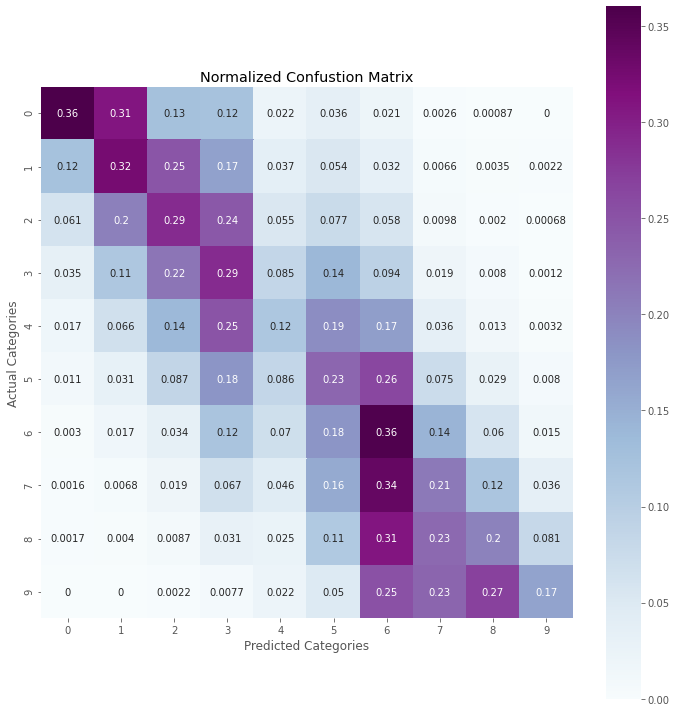

In [32]:
# compare correct and incorrect predictions
plt.figure(figsize=(10, 10))
# np.fill_diagonal(norm_conf_matrix, 0)

ax = sns.heatmap(norm_conf_matrix, 
                 square=True, annot=True, 
                 cmap='BuPu')

plt.ylabel('Actual Categories')
plt.xlabel('Predicted Categories')

plt.title('Normalized Confustion Matrix')
plt.tight_layout()
plt.savefig('03.visualizations/heat_map_gbc.png');

In [35]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

           0      0.380     0.360     0.370      1155
           1      0.303     0.324     0.313      2285
           2      0.271     0.289     0.280      2956
           3      0.228     0.289     0.255      3263
           4      0.230     0.115     0.154      3131
           5      0.216     0.230     0.223      3139
           6      0.234     0.357     0.283      3042
           7      0.260     0.210     0.233      2495
           8      0.280     0.201     0.234      1730
           9      0.317     0.165     0.217       907

    accuracy                          0.255     24103
   macro avg      0.272     0.254     0.256     24103
weighted avg      0.258     0.255     0.250     24103



In [27]:
f_importances = pd.Series(gbc.feature_importances_, 
          X_train.columns).sort_values(ascending=False)

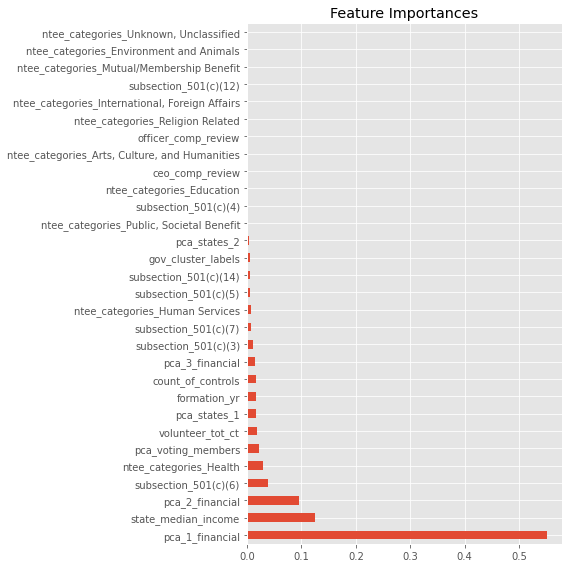

In [31]:
f_importances.plot(kind='barh', figsize=(8, 8))

plt.title('Feature Importances')

plt.tight_layout()

plt.savefig('03.visualizations/gbc_feature_importance.png');

## Examining classification results 

### 1. Compare category assignment salaries against actual salaries and compute MSE(mean squared error)

In [33]:
# import dict with mean salary for each category
category_median_salary = pd.read_csv('02.data/category_median_salary.csv', squeeze=True).to_dict()

In [34]:
# access median salary for each category within dictionary
pd.Series(pred).apply(lambda x: category_median_salary[x])

0        187775.0
1         85079.0
2         85079.0
3        101667.5
4        152129.0
           ...   
24098    152129.0
24099    101667.5
24100    187775.0
24101    152129.0
24102    333669.0
Length: 24103, dtype: float64

In [37]:
np.sqrt(mean_squared_error(y_test, pd.Series(pred).apply(lambda x: category_median_salary[x])))

177270.67978156684

### 2. Compare composite salaries against actual salaries and compute MSE(mean squared error)

In [39]:
# examine probability of assignment
# to specific categories
prob_pred = pd.DataFrame(gbc.predict_proba(X_test))

In [40]:
prob_pred

,0,1,2,3,4,5,6,7,8,9
0,0.001774,0.018043,0.041709,0.083034,0.154682,0.176835,0.229508,0.146426,0.105346,0.042643
1,0.030113,0.115326,0.203852,0.201319,0.178350,0.131144,0.069374,0.041216,0.026350,0.002954
2,0.002249,0.063606,0.234924,0.234051,0.189921,0.145838,0.076126,0.031245,0.017943,0.004097
3,0.002091,0.036134,0.152543,0.207026,0.203924,0.187365,0.130536,0.057097,0.017375,0.005909
4,0.002378,0.012751,0.073072,0.148667,0.178554,0.253317,0.196828,0.085904,0.036579,0.011951
...,...,...,...,...,...,...,...,...,...,...
24098,0.060568,0.065452,0.074778,0.148999,0.170301,0.182052,0.151408,0.109392,0.030664,0.006388
24099,0.002366,0.013693,0.154760,0.301490,0.213528,0.184458,0.073075,0.032969,0.018825,0.004836
24100,0.006078,0.046732,0.050499,0.077877,0.113555,0.126456,0.368146,0.176804,0.027957,0.005894
24101,0.012426,0.019972,0.031422,0.062543,0.116821,0.182286,0.178606,0.161667,0.125418,0.108838


In [41]:
# import dict with mean salary for each category
category_median_salary = pd.read_csv('02.data/category_median_salary.csv', squeeze=True).to_dict()

In [42]:
# examine dictionary to make sure it looks as it should
category_median_salary

{0: 60000.0,
 1: 72000.0,
 2: 85079.0,
 3: 101667.5,
 4: 122761.0,
 5: 152129.0,
 6: 187775.0,
 7: 241712.0,
 8: 333669.0,
 9: 537557.5}

In [44]:
# multipy each column probability by 
# the median value for that salary category
frac_salary = pd.DataFrame(prob_pred)

for column in frac_salary.columns:
    frac_salary[column] = frac_salary[column] * category_median_salary[column]

In [45]:
frac_salary

,0,1,2,3,4,5,6,7,8,9
0,106.414390,1299.086014,3548.546981,8441.889446,18988.933399,26901.780677,43095.929983,35392.942767,35150.698276,22922.805311
1,1806.781413,8303.478777,17343.566247,20467.633725,21894.445133,19950.824114,13026.772951,9962.326670,8792.333626,1588.069808
2,134.932559,4579.623213,19987.082734,23795.344235,23314.939840,22186.220063,14294.539046,7552.280264,5987.137034,2202.377926
3,125.483791,2601.683033,12978.165740,21047.804159,25033.921812,28503.586034,24511.351980,13801.000749,5797.492720,3176.666106
4,142.664993,918.049891,6216.929886,15114.567272,21919.406614,38536.902741,36959.357255,20764.063567,12205.238801,6424.226461
...,...,...,...,...,...,...,...,...,...,...
24098,3634.069329,4712.515904,6362.053480,15148.308666,20906.288092,27695.376571,28430.559501,26441.420106,10231.489139,3433.790611
24099,141.947743,985.867494,13166.826685,30651.686306,26212.946584,28061.409926,13721.690031,7969.064224,6281.407512,2599.678905
24100,364.701591,3364.726725,4296.432441,7917.583876,13940.090035,19237.651660,69128.702805,42735.641604,9328.497671,3168.413458
24101,745.559374,1437.962428,2673.353191,6358.564768,14341.026709,27731.039020,33537.784784,39076.937722,41848.265384,58506.913070


In [46]:
np.sqrt(mean_squared_error(y_test, frac_salary.sum(axis=1)))

174944.693747964

### 3. Compare category assignment for top two categories against actual salaries and compute MSE(mean squared error)

In [47]:
# find top two percents
top_two_prob = pd.DataFrame(prob_pred).apply(lambda x: pd.Series(x.nlargest(2)), axis=1)

In [48]:
# prorate percentages to 100% total
top_two_prob = top_two_prob.div(top_two_prob.sum(axis=1), axis=0)

In [49]:
# multiply each percent by 
# corresponding median category level
for column in top_two_prob.columns:
    top_two_prob[column] = top_two_prob[column] * category_median_salary[column]

In [50]:
np.sqrt(mean_squared_error(y_test, top_two_prob.sum(axis=1)))

218936.26685505893

### Comparison between all methods

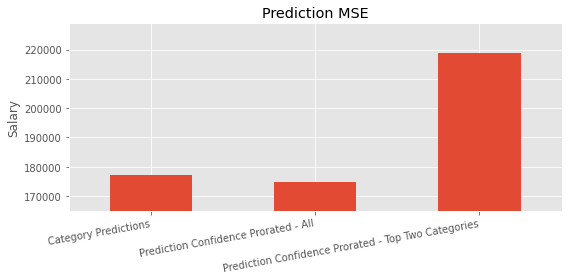

In [51]:
# combine adjustments to be able to plot
# and visualize differences between each
ax = pd.DataFrame(index=['Category Predictions',
    'Prediction Confidence Prorated - All',
    'Prediction Confidence Prorated - Top Two Categories'],
data=[np.sqrt(mean_squared_error(y_test, pd.Series(pred).apply(lambda x: category_median_salary[x]))),
np.sqrt(mean_squared_error(y_test, frac_salary.sum(axis=1))),
np.sqrt(mean_squared_error(y_test, top_two_prob.sum(axis=1)))]).plot(kind='bar',
                                                                      figsize=(8,4), 
                                                                    legend=False)

plt.ylim((pd.DataFrame(index=['Category Predictions',
    'Prediction Confidence Prorated - All',
    'Prediction Confidence Prorated - Top Two Categories'],
data=[np.sqrt(mean_squared_error(y_test, pd.Series(pred).apply(lambda x: category_median_salary[x]))),
np.sqrt(mean_squared_error(y_test, frac_salary.sum(axis=1))),
np.sqrt(mean_squared_error(y_test, top_two_prob.sum(axis=1)))]).min() - 10000).values,
         (pd.DataFrame(index=['Category Predictions',
    'Prediction Confidence Prorated - All',
    'Prediction Confidence Prorated - Top Two Categories'],
data=[np.sqrt(mean_squared_error(y_test, pd.Series(pred).apply(lambda x: category_median_salary[x]))),
np.sqrt(mean_squared_error(y_test, frac_salary.sum(axis=1))),
np.sqrt(mean_squared_error(y_test, top_two_prob.sum(axis=1)))]).max() + 10000).values)

plt.title('Prediction MSE')
plt.ylabel('Salary')
plt.xticks(rotation=10, horizontalalignment="right")

plt.tight_layout()
plt.savefig('03.visualizations/classification_adjust.png');

The difference is actually quite small, nevertheless there is some benefit to adjusting based on the probability of assignment.